# IEEE NASC 2024 - Predict Data Center Missing Resource Usage Data

**Author**: Aryamaan Dhomne

Welcome to the Data Center Missing Resource Usage Imputation Challenge!

In this competition, you will work with resource usage data from a supercomputer. The data consists of various metrics like CPU usage, memory consumption, GPU activity, and data transfer rates. However, some data values are missing.

Your objective is to impute missing values at a consistent two-minute interval using different techniques. By resampling the data and applying imputation methods, you'll create a complete time series ready for further analysis.

In this notebook, we explore an example solution for working with this data. We use an XGBoost-based autoregressive model and cover some basic data exploration and feature engineering techniques.

# Setup/Imports

In [6]:
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_missing_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/grading_jobs_misisng_data.csv

--2024-10-22 04:26:10--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 3.5.29.119, 52.216.44.65, 3.5.0.52, ...
Connecting to fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)|3.5.29.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12156758 (12M) [text/csv]
Saving to: ‘participant_training_jobs_full_data.csv.1’

participant_trainin 100%[===================>]  11.59M  17.0MB/s    in 0.7s    

2024-10-22 04:26:11 (17.0 MB/s) - ‘participant_training_jobs_full_data.csv.1’ saved [12156758/12156758]

--2024-10-22 04:26:11--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 3.5.29.119, 52.216.44.65,

In [7]:
!pip install darts

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from darts import TimeSeries

# Preprocess Data
In this section, we pivot the dataframe to create a wider table, where metrics are aligned by timestamp

We also create two new columns:
- `relative_index`: index within each job to each record
- `time_since_job_start` the number of seconds that have elapsed since the job started

In [39]:
train_df = pd.read_csv("./participant_training_jobs_full_data.csv")
test_df = pd.read_csv("./participant_test_jobs_full_data.csv")
test_missing_df = pd.read_csv("./participant_test_jobs_missing_data.csv")
grading_df = pd.read_csv("./grading_jobs_misisng_data.csv")

In [42]:
event_cols = ['block', 'cpuuser', 'gpu_usage', 'memused', 'memused_minus_diskcache', 'nfs']
groupby_cols = ['job_id', 'host']

In [43]:
dfs = [train_df, test_df, test_missing_df, grading_df]
for df in dfs:
  df['relative_index'] = df.groupby(groupby_cols).cumcount()

In [44]:
for df in dfs:
  df['time_since_job_start'] = 0
  for (job_id, host), group in df.groupby(groupby_cols):
    group['time_since_job_start'] = group.ts_delta * group.relative_index
    df.loc[group.index, 'time_since_job_start'] = group.time_since_job_start
  df.time_since_job_start = df.time_since_job_start.astype(int)

# Training Imputation models
Based on the plots above, it looks like most of our usage metrics are autocorrelated. Let's choose a lag value of 5 to train our model and use the XGBModel from [darts](https://unit8co.github.io/darts/)

In [13]:
from darts.models import LightGBMModel
from darts import TimeSeries

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [14]:
# Create TimeSeries objects for darts models
# Use the time_since_job_start as the time index for each time series
train_ts_list = []
train_df_grouped = train_df.groupby(groupby_cols)
for (job_id, host), group_df in train_df_grouped:
    ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
    # converting to a float32 since MPS (Apple ARM acceleration) does not support float64
    # you may not need to do this!
    train_ts_list.append(ts.astype(np.float32))

In [15]:
from darts.models import RNNModel, LightGBMModel
from darts.models.forecasting.lgbm import LightGBMModel
from sklearn.metrics import mean_squared_error
import torch

lstm_model = RNNModel(
    model='LSTM',
    input_chunk_length=5,    # Sequence length of past data
    output_chunk_length=1,    # Predict next time step
    n_epochs=10,             # Number of training epochs
    random_state=42
)

lstm_model.fit(train_ts_list)

# Step 2: Generate LSTM outputs as features for the LightGBM model
lstm_features = []
for ts in train_ts_list:
    lstm_pred = lstm_model.historical_forecasts(ts, retrain=False)
    lstm_features.append(lstm_pred.pd_dataframe())  # Collect predictions as features

# Step 3: Combine LSTM features with the original feature set for LightGBM
lstm_feature_df = pd.concat(lstm_features)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.3 K  | train
6 | V               | Linear           | 156    | train
-------------------------------------------------------------
3.5 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_R

In [16]:
train_df = train_df.reset_index(drop=True)
lstm_feature_df = lstm_feature_df.reset_index(drop=True)

# # Now you can safely concatenate
X_train_combined = pd.concat([train_df, lstm_feature_df], axis=1)

X_ts = []
X_df_grouped = X_train_combined.groupby(groupby_cols)
for (job_id, host), group_df in train_df_grouped:
    ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
    X_ts.append(ts.astype(np.float32))


In [17]:
# Assuming 'time_since_job_start' is your time column and 'target_variable' is the column you want to predict

# Now you can fit the model with the TimeSeries object
model = LightGBMModel(lags=5)
model.fit(X_ts)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 87992, number of used features: 30
[LightGBM] [Info] Start training from score 0.000021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 87992, number of used features: 30
[LightGBM] [Info] Start training from score 12.640378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train se

LightGBMModel(lags=5, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

# Model Evaluation

Now that we've trained our model, let's evaluate it on the test dataset so we know if our model works!

In [18]:
# we're using a dict here so that we can get predictions for specific job_id/host combinations
# this will be useful for plotting later on
test_ts_list = {}
test_df_grouped = test_df.groupby(groupby_cols)
for (job_id, host), group_df in test_df_grouped:
  ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
  test_ts_list[(job_id, host)] = ts.astype(np.float32)

In [19]:
imputed_df = test_missing_df.copy()
# update imputed_df index so it's easier to set values
imputed_df = imputed_df.set_index([*groupby_cols, 'timestamp'])
for (job_id, host), ts in list(test_ts_list.items()):
  # Use the TS model to predict our event columns "in the past"
  # note that our first output will be at the 5th record, since we use a lag value of 5
  pred = model.historical_forecasts(ts, retrain=False).pd_dataframe()
  missing_job_df = test_missing_df[(test_missing_df.job_id == job_id) & (test_missing_df.host == host)].set_index('time_since_job_start')
  nan_indexes = missing_job_df[missing_job_df.isna().any(axis=1)].index
  # filter the nan indexes since we don't have data for the first 5 records (t<600s)
  nan_indexes = nan_indexes[nan_indexes > 600]
  missing_job_df.loc[nan_indexes, event_cols] = pred.loc[nan_indexes, event_cols]
  # fill the first 5 records with the average of the rest of the data (there's probably room for imporovement here!)
  missing_job_df[event_cols] = missing_job_df[event_cols].fillna(missing_job_df[event_cols].mean())
  missing_job_df = missing_job_df.reset_index().set_index([*groupby_cols, 'timestamp'])
  imputed_df.loc[missing_job_df.index] = missing_job_df

In [60]:
import math
from sklearn.metrics import mean_squared_error

# Ensure dataframes are sorted and indexed
imputed_df = imputed_df.reset_index().sort_values([*groupby_cols, 'timestamp']).reset_index(drop=True)
test_df = test_df.reset_index().sort_values([*groupby_cols, 'timestamp']).reset_index(drop=True)
test_missing_df = test_missing_df.sort_values([*groupby_cols]).reset_index(drop=True)


# Fill missing values in the naive imputation
naive_imputed_df = test_missing_df.copy()
naive_imputed_df[event_cols] = test_missing_df[event_cols].fillna(test_missing_df[event_cols].mean())

# Identify rows with missing values (where predictions were made)
nan_idxs = test_missing_df[test_missing_df[event_cols].isna().any(axis=1)].index

# Calculate RMSE for each event column

avg_rsme = 0
for col in event_cols:
    xgb_rmse = math.sqrt(mean_squared_error(imputed_df.loc[nan_idxs, col], test_df.loc[nan_idxs, col]))
    naive_rmse = math.sqrt(mean_squared_error(naive_imputed_df.loc[nan_idxs, col], test_df.loc[nan_idxs, col]))
    avg_rsme += xgb_rmse

    print(f"Column: {col}")
    print(f"light model RMSE: {xgb_rmse}")
    print(f"Naive mean RMSE: {naive_rmse}")
    print("-" * 30)
print(avg_rsme/6)

Column: block
light model RMSE: 0.0006056496445283365
Naive mean RMSE: 0.00036885310876262514
------------------------------
Column: cpuuser
light model RMSE: 1.219798618089116
Naive mean RMSE: 15.813392186347695
------------------------------
Column: gpu_usage
light model RMSE: 9.931131910647258
Naive mean RMSE: 28.6171133152018
------------------------------
Column: memused
light model RMSE: 5.656418307413213
Naive mean RMSE: 48.51549713804645
------------------------------
Column: memused_minus_diskcache
light model RMSE: 5.373049854841546
Naive mean RMSE: 47.32913165582136
------------------------------
Column: nfs
light model RMSE: 0.8727784222171515
Naive mean RMSE: 1.021595055074624
------------------------------
3.8422971271421353


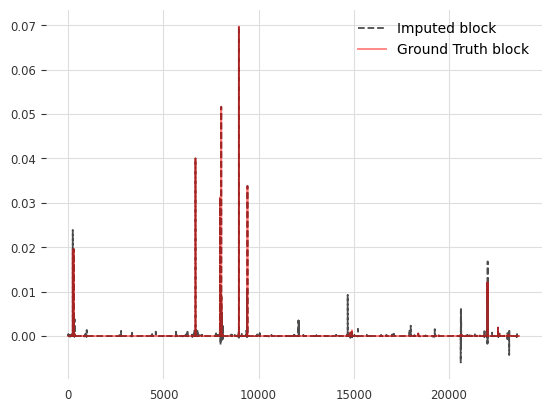

RMSE: 0.00036837266809539336


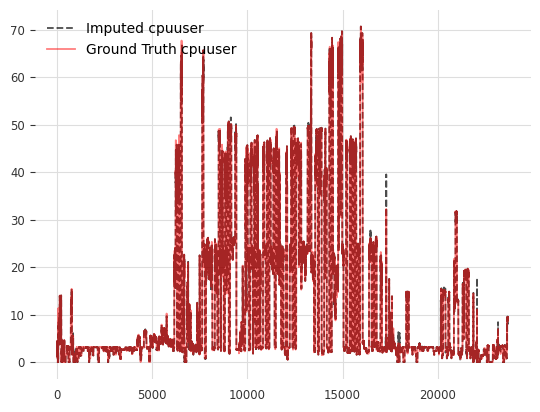

RMSE: 0.7419148604214828


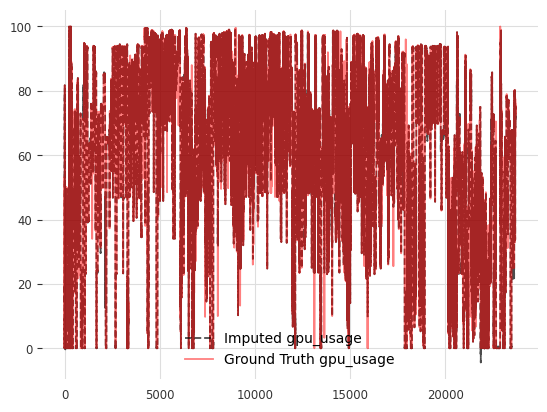

RMSE: 6.040385876857009


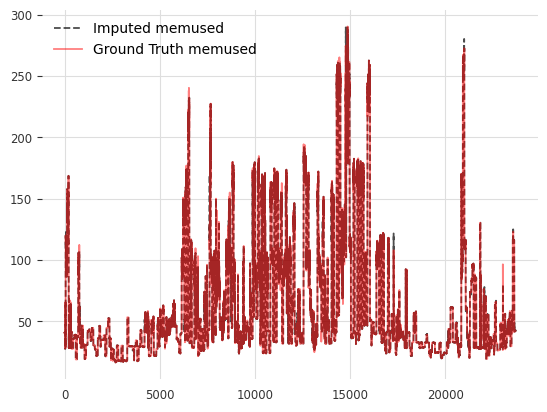

RMSE: 3.440388222118316


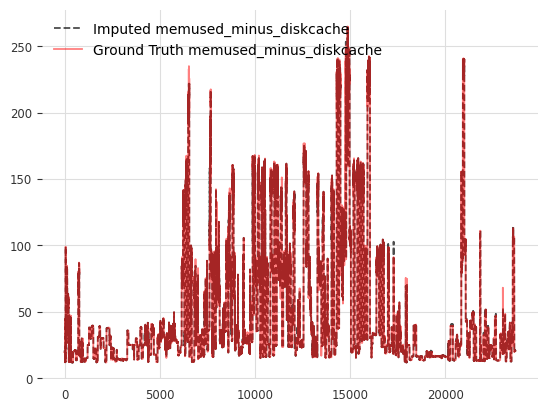

RMSE: 3.2680357839208503


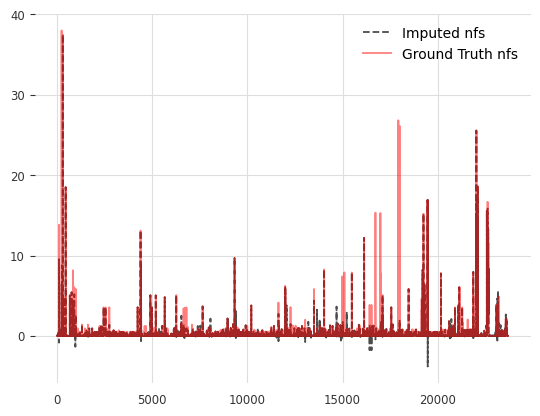

RMSE: 0.5308476921481582


In [57]:

val_p = imputed_df
val_t = test_df
for col in ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  if error.any() < 0:
    print("ERERER")
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

# Grading dataset prediction

Nice! It looks like our XGB performs significantly better than the Naive mean fill. Now let's run our model on the grading dataset and submit our prediction.

In [22]:
grade_ts_list = {}
grade_df_grouped = grading_df.groupby(groupby_cols)
for (job_id, host), group_df in grade_df_grouped:
  ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
  grade_ts_list[(job_id, host)] = ts.astype(np.float32)

In [23]:
imputed_grade_df = grading_df.copy()
imputed_grade_df = imputed_grade_df.set_index([*groupby_cols, 'timestamp'])
for (job_id, host), ts in list(grade_ts_list.items()):
  pred = model.historical_forecasts(ts, retrain=False).pd_dataframe()
  missing_job_df = grading_df[(grading_df.job_id == job_id) & (grading_df.host == host)].set_index('time_since_job_start')
  nan_indexes = missing_job_df[missing_job_df.isna().any(axis=1)].index
  nan_indexes = nan_indexes[nan_indexes > 600]
  missing_job_df.loc[nan_indexes, event_cols] = pred.loc[nan_indexes, event_cols]
  missing_job_df[event_cols] = missing_job_df[event_cols].fillna(missing_job_df[event_cols].mean())
  missing_job_df = missing_job_df.reset_index().set_index([*groupby_cols, 'timestamp'])
  imputed_grade_df.loc[missing_job_df.index] = missing_job_df

In [24]:
imputed_grade_df.reset_index().to_csv("prediction.csv")